# Demonstration of the SCF Voting Mechanism for PoC Purposes

*BlockScience, July 2023*

## Intro

On this Notebook, we'll provide a stylized demonstration for how
Neural Governance could be implemented along with four of its modules: Quorum Voting Neuron, Trust Neuron, Voting History Neuron and Reputation Neuron. Detailed instructions can be found on the [SCF Voting Mechanism PoC Specification](https://hackmd.io/GMs8iB1MQEGsJirqqPm3NA) and [SDF Voting Mechanism PoC Design](https://hackmd.io/HzRrf1NtQ_a7nlSvX_stXg?both) documents.

This Notebook is divided into the following sections:

1. Code Dependencies & Definitions
2. User Data Generation
3. Voting Mechanism PoC
   1. Neural Governance Definition
   2. Neuron Definitions
      1. Quorum Delegation
      2. Reputation Score
      3. Prior Voting Score
      4. Trust Graph Bonus
   3.  The Decision Rule for Funding Projects
   4.  Setting Up the Neural Governance Environment
4.  Compute Voting Results
5.  Visualizations

## 1. Code Dependences, Data Structures and Definitions

In [1]:
from enum import Enum, auto
from functools import reduce
from collections import defaultdict
from dataclasses import dataclass
from random import choices, randint, seed, random, shuffle
import matplotlib.pyplot as plt

import networkx as nx


In [2]:
UserUUID = str
ProjectUUID = str
VotingPower = float

class Vote(float, Enum):
    """
    The Voting Actions towards a Project that a User can take and the 
    values in terms of Voting Power.
    """
    Yes = 1.0
    No = -1.0
    Abstain = 0.0

class Action(Enum):
    """
    The Decisions that a User can make in a Round.
    """
    RoundVote = auto()
    Delegate = auto()
    Abstain = auto()

In [3]:
# Seed numbers for reproducibility
SEED = 7202317
seed(SEED)

## 2. User Data Generation

In [4]:
# Data Generation Parameters
N_PROJECTS = 20
N_USERS = 50
N_VOTING_USERS = 30
N_DELEGATING_USERS = 10
N_ABSENTEE_USERS = N_USERS - (N_VOTING_USERS + N_DELEGATING_USERS)

## Part 1 - Generate Vote/Delegate Actions

# Generate voting, delegating and absentee users in terms of labels
users_voting = [f"u.v-{i}" for i in range(N_VOTING_USERS)]
users_delegating = [f"u.d-{i}" for i in range(N_DELEGATING_USERS)]
users_absent = [f"u.a-{i}" for i in range(N_ABSENTEE_USERS)]
USERS = users_voting + users_delegating + users_absent

# Generate projects
PROJECTS = [f"p-{i + 1}" for i in range(N_PROJECTS)]

# Probability for a Voting User deciding to Vote or Not Vote (Abstain) for a project
PROJECT_VOTE_PROBABILITY = 0.33

# Project Vote Probability when a User is voting on a project
VOTE_PROBABILITY = {
    Vote.Yes: 0.8,
    Vote.No: 0.2
}

# Randomly assign the project votes to the Voting Users.
choices_args = [list(VOTE_PROBABILITY.keys()), list(VOTE_PROBABILITY.values())]
ACTIONS_VOTE = {user: (Action.RoundVote, 
                       {project: choices(*choices_args)[0] 
                        for project in PROJECTS
                         if random() < PROJECT_VOTE_PROBABILITY})
                for user in users_voting}

# Each delegating user will uniformly sample between 5-10 candidate delegatees 
# among the full user population
ACTIONS_DELEGATE = {user: (Action.Delegate, choices([u for u in USERS if u != user], k=randint(5, 10)))
                     for user in users_delegating}

# Concatenate Vote and Delegate actions together
USER_ACTIONS = {**ACTIONS_VOTE, **ACTIONS_DELEGATE}


## Part 2 - Generate Trust Graph

shuffle(USERS)
label_map = {i: USERS[i] for i in range(N_USERS)}
USERS = sorted(USERS)
G = nx.scale_free_graph(N_USERS,
                        alpha=0.41,
                        beta=0.54,
                        gamma=0.05,
                        delta_in=0.2,
                        delta_out=0.0,
                        seed=SEED,
                        initial_graph=None)

G = nx.relabel_nodes(nx.DiGraph(G), label_map)
G = nx.DiGraph(G)
TRUST_GRAPH = nx.to_dict_of_lists(G)

## 3. Voting Mechanism PoC

### 3.1. Neural Governance Definition

In [5]:
# Attribute Voting Power to a (user, project) tuple
def user_project_vote_power(uid: UserUUID, 
                            pid: ProjectUUID, 
                            neuron_layers: tuple[dict, callable],
                            initial_votes: float=0.0,
                            print_on_each_layer=False) -> VotingPower:
    """
    Computes a User Vote towards a Project as based on 
    a Feedforward implementation of Neural Governance for a strictly
    sequential network (no layer parallelism).
    """
    current_vote = initial_votes
    if print_on_each_layer:
            print(f"Layer {0}: {current_vote}")
    for i, layer in enumerate(neuron_layers):
        (neurons, layer_aggregator) = layer
        neuron_votes = []
        for (neuron_label, neuron) in neurons.items():
            (oracle_function, weighting_function) = neuron
            raw_neuron_vote = oracle_function(uid, pid, current_vote)
            neuron_votes.append(weighting_function(raw_neuron_vote))
        current_vote = layer_aggregator(neuron_votes)

        if print_on_each_layer:
            print(f"Layer {i+1}: {current_vote}")

    return current_vote

### 3.2. Defining Neurons

#### 3.2.1. Quorum Delegation

In [6]:
def query_user_quorum(user_id: UserUUID,
                      max_quorum_size: int=5) -> list[UserUUID]:
    """
    Retrieves the Actual Quorum for a given delegating user.
    Returns `None` if the User is not delegating.
    """
    (action, payload) = USER_ACTIONS[user_id]
    actual_quorum = None
    
    if action == Action.Delegate:
        actual_quorum = []
        current_delegatees = payload
        for delegatee in current_delegatees:
            delegatee_action = USER_ACTIONS.get(delegatee, None)
            if delegatee_action is None:
                continue
            else:
                action = delegatee_action[0]
                if action == Action.RoundVote:
                    actual_quorum.append(delegatee)

                if len(actual_quorum) == max_quorum_size:
                    return actual_quorum

        return actual_quorum
    else:
        return None


def quorum_participation(quorum: list[UserUUID],
                         project_id: ProjectUUID,
                         quorum_size: int=5) -> float:
    """
    Active participation share of a quorum towards a project.
    """
    active_delegatees = 0
    for delegatee in quorum:
        if USER_ACTIONS[delegatee][1].get(project_id, None) is not None:
            active_delegatees += 1

    return active_delegatees / quorum_size


def quorum_agreement(quorum: list[UserUUID],
                     project_id: ProjectUUID,
                     initial_agreement: float=0.0) -> float:
    """
    Compute the quorum agreement for the active participants
    """
    agreement = initial_agreement
    quorum_size = 0
    for delegatee in quorum:
        delegatee_action = USER_ACTIONS.get(delegatee, None)
        action = USER_ACTIONS[delegatee][1].get(project_id, None)
        # Note: this logic would be different if we were to weight by User Voting Power
        if action is not None:
            quorum_size += 1
            if action is Vote.Yes:
                agreement += 1
            elif action is Vote.No:
                agreement += -1
            else:
                agreement += 0
    return agreement / quorum_size


def query_user_vote(user_id, project_id) -> Vote | Action:
    
    (action, payload) = USER_ACTIONS.get(user_id, (None, None))
    if action is None:
        return Vote.Abstain
    
    if action is Action.RoundVote:
        project_vote = payload.get(project_id, None)
        if project_vote is None:
            return Vote.Abstain
        else:
            return project_vote

    if action is Action.Delegate:
        return Action.Delegate


def quorum_delegate_result(user_id,
                           project_id,
                           participation_threshold=0.66,
                           agreement_threshold=0.5):
    """
    Oracle Module for the Quorum Delegation Neuron.
    """
    
    vote = query_user_vote(user_id, project_id)

    if vote is Action.Delegate:
        quorum = query_user_quorum(user_id)
        if quorum_participation(quorum, project_id) > participation_threshold:
            agreement = quorum_agreement(quorum, project_id)
            if agreement > agreement_threshold:
                return Vote.Yes
            elif agreement < -agreement_threshold:
                return Vote.No
            else:
                return Vote.Abstain
        else:
            return Vote.Abstain
    else:
        return vote

#### 3.2.2. Reputation Score

In [7]:
class ReputationCategory(Enum):
    Tier3 = auto()
    Tier2 = auto()
    Tier1 = auto()
    Uncategorized = auto()

@dataclass
class ReputationAPI():
    status: int
    reputation_category: ReputationCategory

    def get(user_id):
        return ReputationAPI(status=200, 
                             reputation_category=ReputationCategory.Uncategorized)


REPUTATION_SCORE_MAP = {
    ReputationCategory.Tier3: 0.3,
    ReputationCategory.Tier2: 0.2,
    ReputationCategory.Tier1: 0.1,
    ReputationCategory.Uncategorized: 0.0
}

def reputation_score(user_id) -> VotingPower:
    """
    Oracle Module for the Reputation Score
    """
    bonus = 0.0
    api_result = ReputationAPI.get(user_id)
    if api_result.status == 200:
        bonus = REPUTATION_SCORE_MAP[api_result.reputation_category]
    return bonus

#### 3.2.3. Prior Voting Score

In [8]:
@dataclass
class PastVotingAPI():
    status: int
    active_rounds: list[int]

    def get(user_id):
        return PastVotingAPI(status=200, 
                             active_rounds=[2, 3])

ROUND_BONUS_MAP = {
    1: 0.0,
    2: 0.1,
    3: 0.2,
    4: 0.3
}

def prior_voting_score(user_id, project_id, _) -> VotingPower:
    """
    Oracle Module for the Prior Voting Score
    """

    bonus = 0.0
    api_result = PastVotingAPI.get(user_id)
    if api_result.status == 200:
        user_active_rounds = api_result.active_rounds
        for active_round in user_active_rounds:
            bonus += ROUND_BONUS_MAP[active_round]

#### 3.2.4. Trust Graph Bonus

In [9]:
# 1) Definitions

# Key is the Trusting User and the Value Set are the Users being trusted
TrustGraph = dict[UserUUID, list[UserUUID]]

def compute_trust_score(raw_graph: dict) -> dict[UserUUID, float]:
    """
    Computes the Trust Score as based on the Canonical Page Rank.

    This is done by computing the Page Rank on the whole Trust Graph
    with default arguments and scaling the results through MinMax.
    
    The resulting scores will be contained between 0.0 and 1.0
    """
    G = nx.from_dict_of_lists(raw_graph,
                              create_using=nx.DiGraph)

    pagerank_values = nx.pagerank(G, 
                                  alpha=0.85, 
                                  personalization=None, 
                                  max_iter=100,
                                  tol=1e-6,
                                  nstart=None,
                                  weight=None,
                                  dangling=None)
    
    max_value = max(pagerank_values.values())
    min_value = min(pagerank_values.values())
    trust_score = {user: (value - min_value) / (max_value - min_value)
                   for (user, value) in pagerank_values.items()}
    return trust_score

# 2) Backend inputs

TRUST_BONUS_PER_USER = compute_trust_score(TRUST_GRAPH)

# 3) Implementing an Oracle

def trust_score(user_id: UserUUID,
                value_if_missing: float=0.0) -> VotingPower:
    """
    Oracle for the Trust Bonus.
    """
    return TRUST_BONUS_PER_USER.get(user_id, value_if_missing)

#### 3.3. The Decision Rule for Funding Projects

In [10]:
def fund_project(power: VotingPower, count: int) -> bool:
    if (power > 0) & (count >= 2):
        return True
    else:
        return False

### 3.4. Setting up the Neural Governance Environment

In [11]:

LAYER_1_AGGREGATOR = lambda lst: sum(lst)
# Take the product of the list
LAYER_2_AGGREGATOR = lambda lst: reduce((lambda x, y: x * y), lst) 

LAYER_1_NEURONS = {
    'one_person_one_vote': (lambda _1, _2, _3: 1, lambda x: x),
    'trust_score': (lambda uid, _1, _2: trust_score(uid),
                    lambda x: x),
    'reputation_score': (lambda uid, _1, _2: reputation_score(uid),
                         lambda x: x)
}

LAYER_2_NEURONS = {
    'power_before_delegation': (lambda _1, _2, prev_vote: prev_vote,
                                lambda x: x),
    'quorum_delegation': (lambda u, p, _: quorum_delegate_result(u, p), 
                          lambda x: x) # Either 0.0 or 1.0
}

NEURAL_GOVERNANCE_LAYERS = [(LAYER_1_NEURONS, LAYER_1_AGGREGATOR),
                            (LAYER_2_NEURONS, LAYER_2_AGGREGATOR)]



## 4. Compute Voting Results

In [12]:
votes = defaultdict(dict)
project_vote_count = defaultdict(int)
project_vote_power = defaultdict(float)
for project in PROJECTS:
    for user in USERS:
        args = (user, project, NEURAL_GOVERNANCE_LAYERS)
        #print(f"User: {user}, Project: {project}")

        vote = user_project_vote_power(*args, print_on_each_layer=False) 
        project_vote_power[project] += vote
        if vote != 0.0:
            project_vote_count[project] += 1
            votes[user][project] = {'power': vote}
        
        #print("--")
project_result = {project: fund_project(project_vote_power[project], project_vote_count[project])
                  for project in PROJECTS}

for project in PROJECTS:
    print(f"{project}\tFunded: {project_result[project]}\tYes/No Voters: {project_vote_count[project]}\tPower: {project_vote_power[project] :.2f}")

p-1	Funded: True	Yes/No Voters: 10	Power: 6.16
p-2	Funded: True	Yes/No Voters: 15	Power: 10.65
p-3	Funded: True	Yes/No Voters: 14	Power: 6.55
p-4	Funded: True	Yes/No Voters: 8	Power: 6.00
p-5	Funded: True	Yes/No Voters: 17	Power: 10.28
p-6	Funded: True	Yes/No Voters: 11	Power: 10.54
p-7	Funded: True	Yes/No Voters: 3	Power: 1.00
p-8	Funded: True	Yes/No Voters: 15	Power: 9.82
p-9	Funded: True	Yes/No Voters: 8	Power: 6.40
p-10	Funded: True	Yes/No Voters: 7	Power: 4.13
p-11	Funded: True	Yes/No Voters: 11	Power: 5.37
p-12	Funded: True	Yes/No Voters: 10	Power: 6.77
p-13	Funded: True	Yes/No Voters: 9	Power: 5.00
p-14	Funded: True	Yes/No Voters: 11	Power: 7.00
p-15	Funded: True	Yes/No Voters: 14	Power: 12.31
p-16	Funded: True	Yes/No Voters: 9	Power: 1.17
p-17	Funded: True	Yes/No Voters: 12	Power: 8.77
p-18	Funded: True	Yes/No Voters: 8	Power: 4.04
p-19	Funded: True	Yes/No Voters: 14	Power: 12.40
p-20	Funded: True	Yes/No Voters: 12	Power: 11.13


## 5. Visualizations

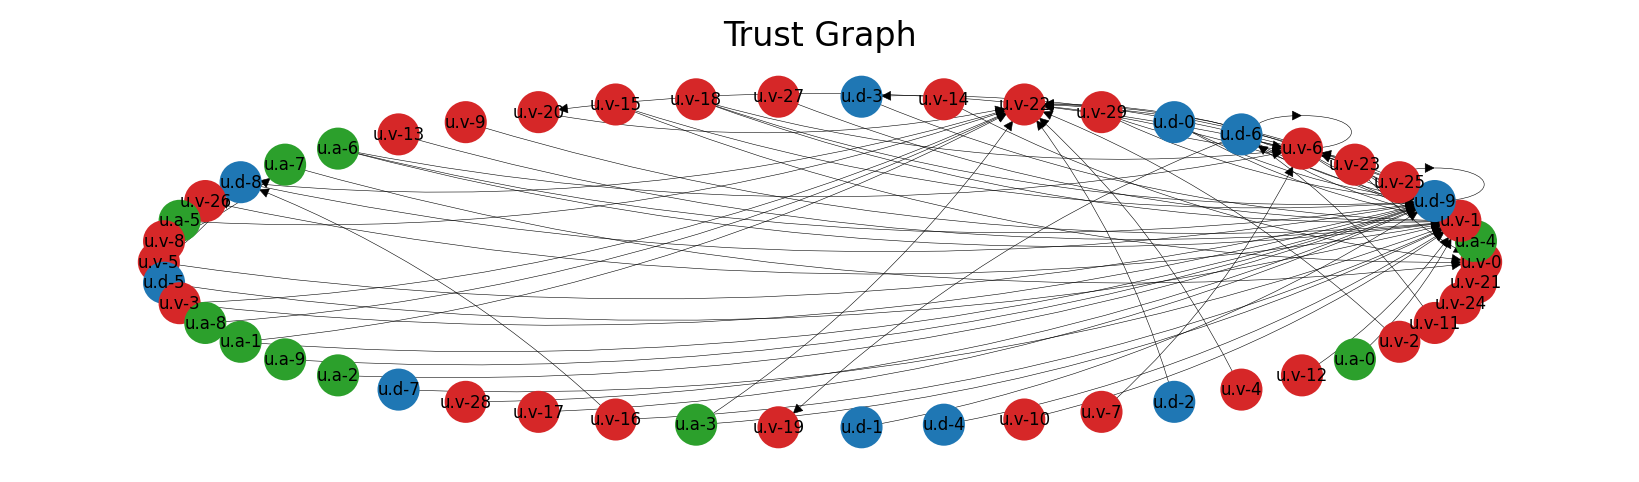

In [13]:
G_trust = nx.DiGraph(TRUST_GRAPH)
G = G_trust

def color_map(x):
    if "u.v" in x:
        return 'tab:red'
    elif "u.d" in x:
        return 'tab:blue'
    elif "u.a" in x:
        return 'tab:green'
    elif "p." in x:
        return 'tab:cyan'
    else:
        return 'white'

COLORS = [color_map(user) for user in G.nodes]

pos = nx.circular_layout(G)

plt.figure(figsize=(8, 2), dpi=200) 
nx.draw(G, pos, 
        with_labels=True, 
        font_size=6, 
        node_size=200,
        width=0.2,
        arrowsize=8, 
        node_color=COLORS,
        connectionstyle='arc3, rad = 0.1')
plt.title("Trust Graph")
plt.show()

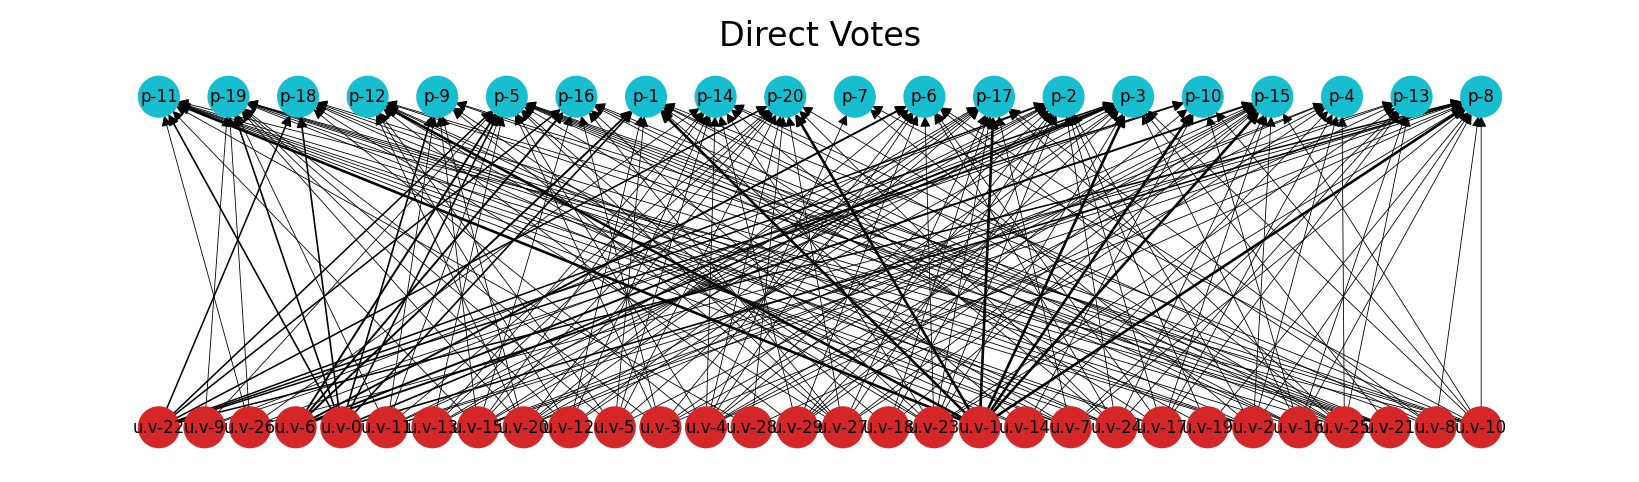

In [14]:
G_votes = nx.DiGraph({user: [proj for proj in action[1].keys()] for user, action in ACTIONS_VOTE.items()})
G = G_votes

edge_weights = [0.3 * user_project_vote_power(u, p, NEURAL_GOVERNANCE_LAYERS) ** 2 for (u, p) in G.edges]

def color_map(x):
    if "u.v" in x:
        return 'tab:red'
    elif "u.d" in x:
        return 'tab:blue'
    elif "u.a" in x:
        return 'tab:green'
    elif "p-" in x: 
        return 'tab:cyan'
    else:
        return 'tab:yellow'

COLORS = [color_map(user) for user in G.nodes]

pos = nx.bipartite_layout(G, nodes=[n for n in G.nodes if "u." in n], align='horizontal')

plt.figure(figsize=(8,2), dpi=200) 
nx.draw(G, pos, 
        with_labels=True, 
        font_size=6, 
        node_size=200,
        #width=0.2,
        arrowsize=8, 
        node_color=COLORS,
        width=edge_weights)
plt.title("Direct Votes")
plt.show()

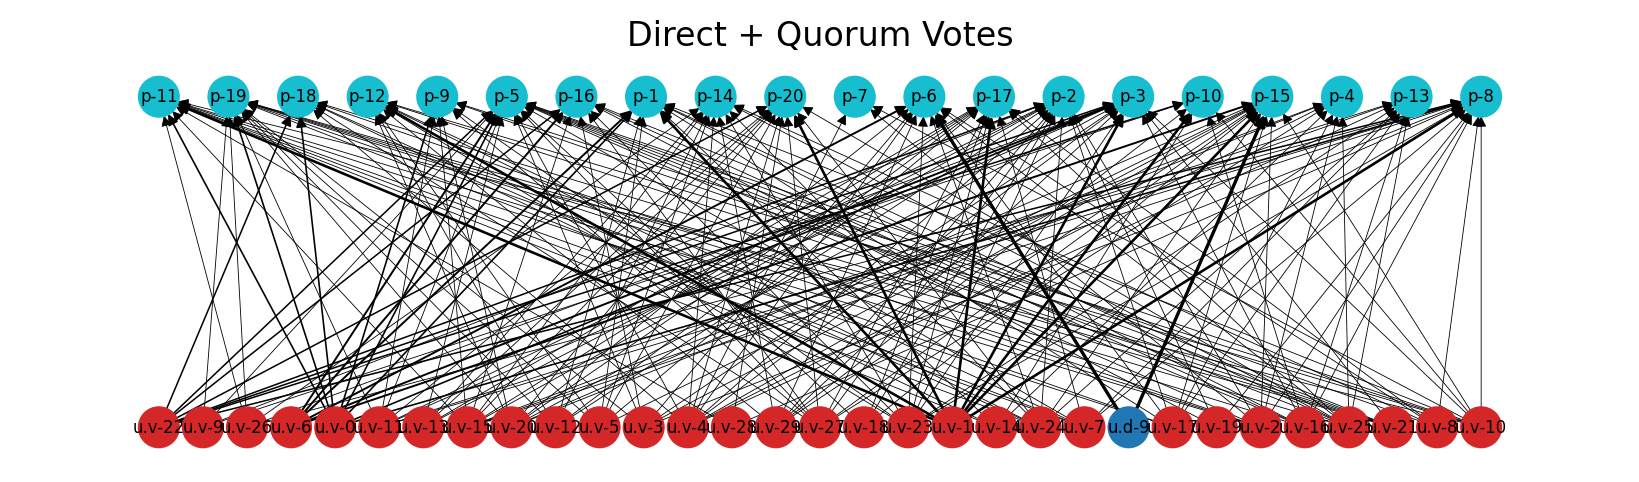

In [15]:
G_votes = nx.from_dict_of_dicts(votes, nx.DiGraph)
G = G_votes
edge_weights = [0.3 * G.edges[e]['power'] ** 2 for e in G.edges]

def color_map(x):
    if "u.v" in x:
        return 'tab:red'
    elif "u.d" in x:
        return 'tab:blue'
    elif "u.a" in x:
        return 'tab:green'
    elif "p-" in x: 
        return 'tab:cyan'
    else:
        return 'tab:yellow'

COLORS = [color_map(user) for user in G.nodes]

pos = nx.bipartite_layout(G, nodes=[n for n in G.nodes if "u." in n], align='horizontal')

plt.figure(figsize=(8,2), dpi=200) 
nx.draw(G, pos, 
        with_labels=True, 
        font_size=6, 
        node_size=200,
        #width=0.2,
        arrowsize=8, 
        node_color=COLORS,
        width=edge_weights)
plt.title("Direct + Quorum Votes")
plt.show()

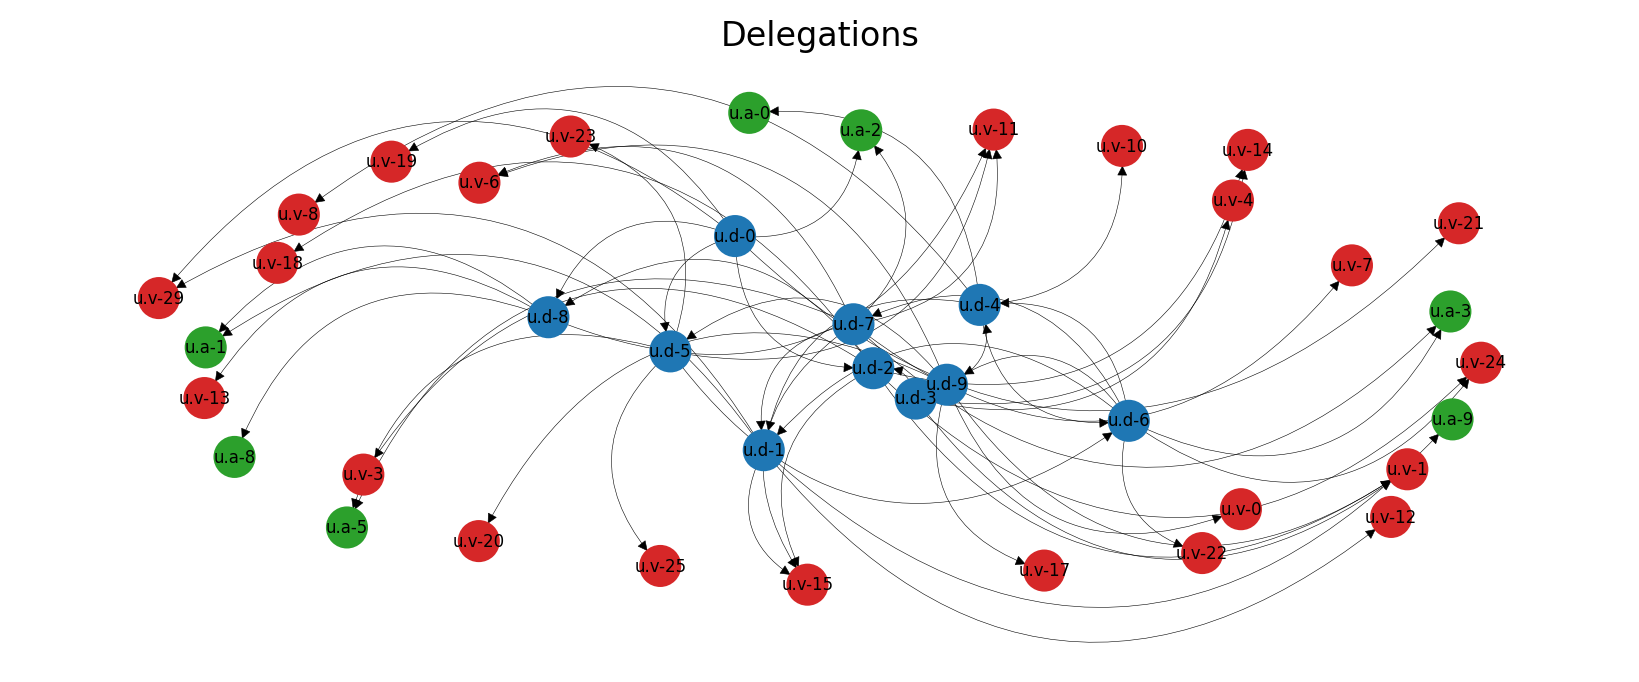

In [16]:
G_delegations = nx.DiGraph({delegating_user: action[1] for delegating_user, action in ACTIONS_DELEGATE.items()})
G = G_delegations

def color_map(x):
    if "u.v" in x:
        return 'tab:red'
    elif "u.d" in x:
        return 'tab:blue'
    elif "u.a" in x:
        return 'tab:green'
    elif "p." in x:
        return 'tab:cyan'
    else:
        return 'white'

COLORS = [color_map(user) for user in G.nodes]

pos = nx.spring_layout(G, seed=SEED, iterations=50, k=1)

plt.figure(figsize=(8, 3), dpi=200) 
nx.draw(G, pos, 
        with_labels=True, 
        font_size=6, 
        node_size=200,
        width=0.2,
        arrowsize=8, 
        node_color=COLORS,
        connectionstyle='arc3, rad=0.5')
plt.title("Delegations")
plt.show()